In [1]:
%load_ext autoreload
%autoreload 2

In [266]:
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp
from functools import partial
from bayes3d.camera import Intrinsics, K_from_intrinsics, camera_rays_from_intrinsics
from bayes3d.transforms_3d import transform_from_pos_target_up, add_homogenous_ones, unproject_depth

key = jax.random.PRNGKey(0)

In [267]:
import traceviz.client
from traceviz.proto import  viz_pb2
import json

In [268]:
from typing import Any, NamedTuple
import jaxlib

Array = np.ndarray | jax.Array
Shape = int | tuple[int, ...]
FaceIndex = int
FaceIndices = Array
ArrayN      = Array
Array3      = Array
Array2      = Array
ArrayNx2    = Array
ArrayNx3    = Array
Matrix      = jaxlib.xla_extension.ArrayImpl
PrecisionMatrix  = Matrix
CovarianceMatrix = Matrix
SquareMatrix     = Matrix
Vector = Array
Direction = Vector
BaseVector = Vector


In [274]:
def bilinear(x:Array, y:Array, A:SquareMatrix):
    return x.T @ A @ y


def log_gaussian(x, mu, omega:PrecisionMatrix):
    """Evaluate an unnormalized gaussian at the given point."""
    return -0.5 * bilinear(x-mu, x-mu, omega)


def gaussian(x, mu, omega:PrecisionMatrix):
    """Evaluate an unnormalized gaussian at the given point."""
    return jnp.exp(-0.5 * bilinear(x-mu, x-mu, omega))


inv = jnp.linalg.inv

In [275]:
THRESH_99 = gaussian(jnp.array([4,0,0]), jnp.zeros(3), jnp.eye(3))
THRESH_97 = gaussian(jnp.array([3,0,0]), jnp.zeros(3), jnp.eye(3))
THRESH_73 = gaussian(jnp.array([2,0,0]), jnp.zeros(3), jnp.eye(3))

In [276]:
def ellipsoid_embedding(cov:CovarianceMatrix):
    """Returns A with cov = A@A.T"""
    sigma, U = jnp.linalg.eigh(cov)
    D = jnp.diag(jnp.sqrt(sigma))
    return U @ D @ jnp.linalg.inv(U)

In [8]:
normal_cdf    = jax.scipy.stats.norm.cdf
normal_pdf    = jax.scipy.stats.norm.pdf
normal_logpdf = jax.scipy.stats.norm.logpdf


In [277]:
def normal_transmittance(t, mu, sig, w=1.0):
    """Evaluate the transmittance of a ray through a gaussian blob."""
    return jnp.exp( - w*normal_cdf( t, loc=mu, scale=sig) + w*normal_cdf(0, loc=mu, scale=sig))

In [278]:
def gaussian_transmittance(t, mu, sig, alpha=1.0):
    """Evaluate the transmittance of a ray through a gaussian blob."""
    N = alpha*(sig*jnp.sqrt(2*jnp.pi))
    return jnp.exp( - N*normal_cdf( t, loc=mu, scale=sig) + N*normal_cdf(0, loc=mu, scale=sig))

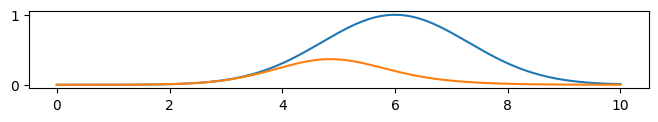

In [279]:
mu  = 6.0
sig = 1.3
ts  = jnp.linspace(0, 10, 1_000)

# Normalization constant
N = sig*jnp.sqrt(2*jnp.pi)

# =========================
plt.figure(figsize=(8, 1))
plt.plot(ts, N*normal_pdf(ts, mu, sig))
plt.plot(ts, N*normal_pdf(ts, mu, sig)*gaussian_transmittance(ts, mu, sig))

In [282]:
def fuzzy_intersection(mu:Vector, omega:PrecisionMatrix, x:Vector, v:Direction):
    """
    Returns the "intersection" of a ray with a gaussian which we define as
    the mode of the gaussian restricted to the ray.
    """
    t = bilinear(mu - x, v, omega)/bilinear(v, v, omega)
    return t

In [335]:
def _cast_ray(v, mus, precisions, colors, zmax=2., bg_color=jnp.array([1.,1.,1.,1.0])):
    # TODO: Deal with negative intersections behind the camera
    # TODO: Maybe switch to log probs?

    # Compute fuzy intersections `xs` with Gaussians and 
    # their function values `sigmas`
    ts     = vmap(fuzzy_intersection, (0,0,None,None))(mus, precisions, jnp.zeros(3), v)
    order  = jnp.argsort(ts)
    ts     = ts[order]
    xs     = ts[:,None]*v[None,:]
    sigmas = vmap(gaussian)(xs, mus[order], precisions[order])

    # Alternatively we can set 
    #   `alphas = sigmas` or 
    #   `alphas = (1 - jnp.exp(-sigmas*1.0))`
    alphas = sigmas
    transmittances = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(1-alphas[:-1])])
    ws = alphas*transmittances # Ordered mixture weights

    mean_depth = jnp.sum(ws*xs[:,2])
    mean_color = jnp.sum(ws[:,None]*colors[order], axis=0)
    
    op = jnp.sum(ws) # Opacity
    mean_depth = mean_depth + (1 - op)*zmax
    mean_color = mean_color + (1 - op)*bg_color
    mean_color = mean_color.at[-1].set(op)
    
    return mean_depth, mean_color, op

cast_rays = jit(vmap(_cast_ray, (0,None,None,None)))

In [336]:
data = jnp.load("data/gaussians_banana_150.npz")
# data = jnp.load("data/gaussians_scissors_550.npz")

nums  = data["nums"]
valid = nums>0
mus   = data["mus"][valid]
covs  = data["covs"][valid]
mean_colors = data["mean_colors"][valid]

covs = vmap(lambda cov: cam_pose[:3,:3].T @ cov @ cam_pose[:3,:3])(covs) 
mus  = (mus - cam_pose[:3,3]) @ cam_pose[:3,:3]
precisions = vmap(inv)(2.0**2*covs)

In [337]:
w = 100
h = 100
f = 300
intr = Intrinsics(width = w, height = h,fx = f, fy = f,
            cx = w/2 - 0.5, cy = h/2 - 0.5, near = 1e-6, far = 5.0)


cam_pose = transform_from_pos_target_up(0.7*jnp.array([1.,0,0.5]), jnp.array([0,0,0]), jnp.array([0,1,0]))
cam_K = K_from_intrinsics(intr)
rays  = camera_rays_from_intrinsics(intr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


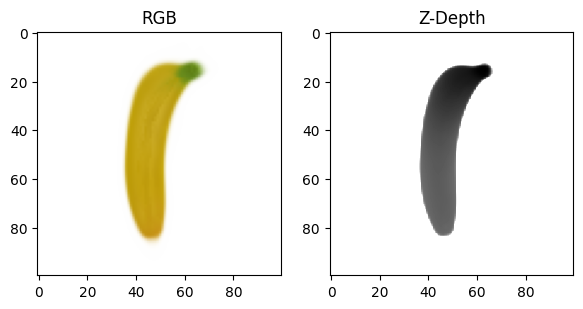

In [338]:
zs, cs, _ = cast_rays(rays.reshape(-1,3), mus, precisions, mean_colors)
zs = zs.reshape(intr.height, intr.width)
cs = cs.reshape(intr.height, intr.width, -1)

fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].set_title("RGB")
axs[0].imshow(cs)
axs[1].set_title("Z-Depth")
axs[1].imshow(zs, cmap="binary_r", vmax=0.9)
fig.tight_layout()

In [329]:
cloud = unproject_depth(zs[::-1,::-1], intr).reshape(-1,3)

In [330]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "Spheres"})
msg.payload.data.MergeFrom(
    traceviz.client.to_pytree_msg({
        'centers': np.array(cloud), 
        'colors': np.array(cs[::-1,::-1].reshape(-1,4)), 
        "scales": 0.002*np.ones(len(cloud))
    })
)
    

stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-11-21T18:26:31.031586 :: ipv4:127.0.0.1:49052"

response:  listener_identifiers: "2023-11-21T18:26:31.031586 :: ipv4:127.0.0.1:49052"

